<h1>Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#TODO:" data-toc-modified-id="TODO:-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>TODO:</a></span></li><li><span><a href="#main()" data-toc-modified-id="main()-2"><span class="toc-item-num">2&nbsp;&nbsp;</span><code>main()</code></a></span></li><li><span><a href="#post-main()" data-toc-modified-id="post-main()-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>post-<code>main()</code></a></span></li><li><span><a href="#ML-Stuff" data-toc-modified-id="ML-Stuff-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>ML Stuff</a></span></li><li><span><a href="#References-&amp;-Further-Reading:" data-toc-modified-id="References-&amp;-Further-Reading:-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>References &amp; Further Reading:</a></span></li></ul></div>

In [3]:
# import PyTorch
import torch

# standard DS stack
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import pandas as pd
# embed static images in the ipynb
%matplotlib inline 

# neural network package
import torch.nn as nn 
import torch.nn.functional as F

from sklearn import linear_model
import sklearn.preprocessing
import warnings
warnings.filterwarnings('ignore')

# !pip install statsmodels
import statsmodels.api as sm

import os
import time
from IPython.display import clear_output
import preprocessing
import ml_models
import neural_networks

- NN paper:
  - SNPs (number of features) - between 350 and 20,000
  - sample size (number of mice) - between 10,000 and 65,000
  
## TODO:
1. **Combined dataset**  
  - [x] Compare the SNP names from the Charles and Harlan Rivers to find out how much they overlap.
  - [x] Create a combined dataset for the overlapping SNPs in data/both/. 
  - [ ] Save the target matrix for the combined dataset as "targets.csv" 
  - [ ] (optional) Check the coefficient distribution for the combined dataset, i.e. are the top 100 coefs from "C" in the top 200-1000 for "both"?

1. **GANs setup**
  - Train your GANs on the top 100.

1. **NNs**
  - [x] Implement dataloader.
  - [x] Implement MLP architecture.
  - [x] Implement training

1. **Evaluate Models**
  - [ ] Evaluate each model on without added samples
  - [ ] Evaluate each model with added samples

---

In [19]:
def save_X():
    pp = preprocessing.Preprocessing()
    Xs, SNP_names = {}, {}
    Xs["C"], SNP_names["C"] = pp.split_X("C", splits = 20, pct = 0.6)
    print(Xs["C"].shape, SNP_names["C"].shape)
    Xs["C"] = pd.DataFrame(Xs["C"], columns=SNP_names["C"])
    Xs["H"], SNP_names["H"] = pp.split_X("H", splits = 20, pct = 0.6)
    print(Xs["H"].shape, SNP_names["H"].shape)
    Xs["H"] = pd.DataFrame(Xs["H"], columns=SNP_names["H"])

    overlap = set(SNP_names["C"]).intersection(set(SNP_names["H"]))
    print(f"cardinality(overlap): {len(overlap)}")
    Xs["C"] = Xs["C"][list(overlap)]
    Xs["H"] = Xs["H"][list(overlap)]

    print("Saving X ...")
    X = pd.concat([Xs["C"], Xs["H"]])
    X.to_csv("data/X.csv", index=False)

save_X()

Batch: 0.	Time (s): 2.1.	SNPs/s: 0.0
Batch: 5.	Time (s): 9.4.	SNPs/s: 2482.6
Batch: 10.	Time (s): 19.8.	SNPs/s: 2369.8
Batch: 15.	Time (s): 27.1.	SNPs/s: 2590.2
(1780, 56156) (56156,)
Batch: 0.	Time (s): 2.0.	SNPs/s: 0.0
Batch: 5.	Time (s): 14.9.	SNPs/s: 1455.0
Batch: 10.	Time (s): 32.7.	SNPs/s: 1330.4
Batch: 15.	Time (s): 48.1.	SNPs/s: 1354.9
(2281, 52113) (52113,)
cardinality(overlap): 25869
Saving X ...


Saving X ...


---

--- 

## post-`main()`

In [210]:
# Perform the analysis with SNPs selected from SelectKBest.

%time 
from sklearn.feature_selection import SelectKBest, chi2
selectk = SelectKBest(chi2, k=100)

X_dummy = selectk.fit_transform(X_r, Y)
X_dummy.shape, selectk.scores_

Wall time: 0 ns


((1780, 100), (21491,))

In [220]:
torch.topk(torch.Tensor(selectk.scores_), 100)

torch.return_types.topk(
values=tensor([16.4646, 16.2303, 16.2303, 15.8967, 15.6809, 15.6047, 15.6047, 15.5528,
        15.4021, 13.8975, 13.8662, 13.5612, 13.3569, 13.3569, 13.1151, 12.9964,
        12.9187, 12.6300, 12.5502, 12.3182, 12.0947, 12.0738, 12.0590, 12.0514,
        11.9404, 11.9239, 11.8714, 11.8288, 11.7775, 11.5188, 11.4483, 11.4479,
        11.4269, 11.3765, 11.3754, 11.3754, 11.0688, 11.0688, 10.9905, 10.9341,
        10.9100, 10.9053, 10.8866, 10.8635, 10.8580, 10.7840, 10.7840, 10.7840,
        10.7542, 10.7375, 10.7150, 10.7121, 10.7074, 10.6794, 10.6397, 10.6397,
        10.6325, 10.6045, 10.5636, 10.5636, 10.5633, 10.4765, 10.4699, 10.4582,
        10.4493, 10.4434, 10.4314, 10.3176, 10.1845, 10.1309, 10.1106, 10.0951,
        10.0496, 10.0417, 10.0224,  9.9342,  9.9319,  9.9252,  9.8783,  9.8372,
         9.8041,  9.7947,  9.7889,  9.7600,  9.7600,  9.7355,  9.7343,  9.7343,
         9.7257,  9.6761,  9.6577,  9.6470,  9.5917,  9.5916,  9.5811,  9.5563,
        

In [218]:
torch.topk(torch.Tensor(chi2_stats), 100)

torch.return_types.topk(
values=tensor([16.4646, 16.2303, 16.2303, 15.8967, 15.6809, 15.6047, 15.6047, 15.5528,
        15.4021, 13.8975, 13.8662, 13.5612, 13.3569, 13.3569, 13.1151, 12.9964,
        12.9187, 12.6300, 12.5502, 12.3182, 12.0947, 12.0738, 12.0590, 12.0514,
        11.9404, 11.9239, 11.8714, 11.8288, 11.7775, 11.5188, 11.4483, 11.4479,
        11.4269, 11.3765, 11.3754, 11.3754, 11.0688, 11.0688, 10.9905, 10.9341,
        10.9100, 10.9053, 10.8866, 10.8635, 10.8580, 10.7840, 10.7840, 10.7840,
        10.7542, 10.7375, 10.7150, 10.7121, 10.7074, 10.6794, 10.6397, 10.6397,
        10.6325, 10.6045, 10.5636, 10.5636, 10.5633, 10.4765, 10.4699, 10.4582,
        10.4493, 10.4434, 10.4314, 10.3176, 10.1845, 10.1309, 10.1106, 10.0951,
        10.0496, 10.0417, 10.0224,  9.9342,  9.9319,  9.9252,  9.8783,  9.8372,
         9.8041,  9.7947,  9.7889,  9.7600,  9.7600,  9.7355,  9.7343,  9.7343,
         9.7257,  9.6761,  9.6577,  9.6470,  9.5917,  9.5916,  9.5811,  9.5563,
        

In [223]:
SNP_names[np.array(torch.topk(torch.Tensor(chi2_stats), 100)[1])]

array(['chr7.29631577', 'chr2.145686126', 'chr2.145743050',
       'chr2.144811756', 'chr13.46775590', 'chr1.196721088',
       'chr1.196721085', 'chr1.196721089', 'chr7.110434734',
       'chr2.108960762', 'chr17.22777658', 'chr3.104950986',
       'chr3.104990952', 'chr3.104991105', 'chr15.14899164',
       'chr6.39478341', 'chr4.119528150', 'chr4.118967275',
       'chr13.46784040', 'chr3.143256926', 'chr6.130924586',
       'chr18.13497419', 'chr4.119363345', 'chr6.6674844',
       'chr11.33028547', 'chr2.43248723', 'chr1.132793881',
       'chr9.40597849', 'chr12.49835217', 'chr1.19942050',
       'chr3.142909318', 'chr7.110496699', 'chr2.143772703',
       'chr5.99313779', 'chr5.96661534', 'chr5.96661537',
       'chr11.75034553', 'chr11.75034575', 'chr3.103333129',
       'chr14.72625273', 'chr1.19942048', 'chr20.5368892',
       'chr3.68664801', 'chr18.26857012', 'chr9.116352923',
       'chr2.143817940', 'chr2.143822315', 'chr2.143821170',
       'chr13.46746378', 'chr13.46818

In [224]:
X_dummy

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 1., 0.],
       [0., 0., 0., ..., 2., 2., 0.],
       ...,
       [0., 0., 0., ..., 1., 1., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 1., 0.]])

In [214]:
chi2_stats, p_vals = chi2(X_r, Y)
chi2_stats, p_vals
X_r.values[:, np.array(torch.topk(torch.Tensor(chi2_stats), 100)[1])]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [197]:
X_dummy

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 1., 0.],
       [0., 0., 0., ..., 2., 2., 0.],
       ...,
       [0., 0., 0., ..., 1., 1., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 1., 0.]])

## ML Stuff 

Accuracy: 0.44697 (0.07058)

Confusion matrix:
[[144  54  19]
 [100  95  12]
 [ 40  44  26]]

Classification report:
              precision    recall  f1-score   support

           0       0.51      0.66      0.57       217
           1       0.49      0.46      0.47       207
           2       0.46      0.24      0.31       110

    accuracy                           0.50       534
   macro avg       0.49      0.45      0.45       534
weighted avg       0.49      0.50      0.48       534



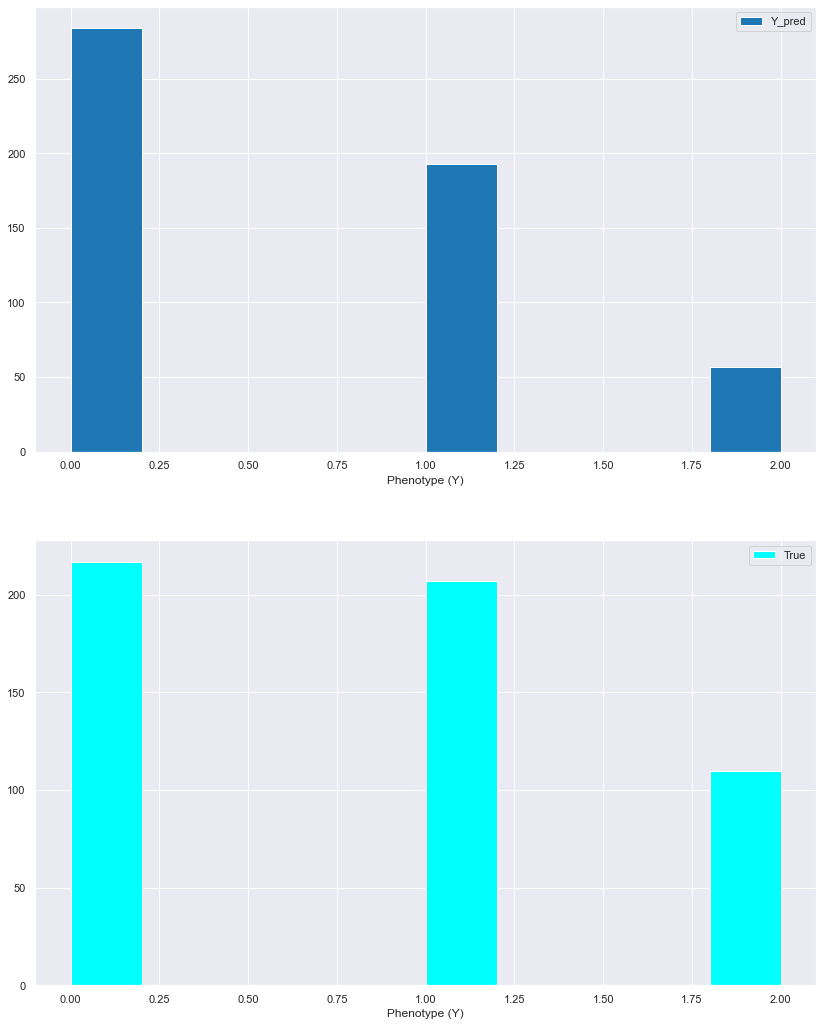

In [269]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

def mlmodel(X, Y):
    X_train, X_test, Y_train, Y_test = train_test_split(
        X.astype(float), Y, test_size=0.3, random_state=7)
    model = SGDClassifier(loss='hinge')
    # model = RandomForestClassifier()
    model.fit(X_train, Y_train)
    Y_pred = model.predict(X_test)
    
    kfold = KFold(n_splits=15)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring='accuracy')
    accuracy = metrics.accuracy_score(Y_test, Y_pred)
    print(f"Accuracy: {cv_results.mean():.5f} ({cv_results.std():.5f})\n"
          + f"\nConfusion matrix:\n{confusion_matrix(Y_test, Y_pred)}\n"
          + f"\nClassification report:\n{classification_report(Y_test, Y_pred)}")
    
    fig, ax = plt.subplots(1, 2, figsize=(14, 2*9))
    ax[0].hist(Y_pred.astype(int), color='#1f77b4', label="Y_pred")
    ax[1].hist(Y_test.astype(int), color='cyan', label="True")
    
    for a in ax:
        a.set(xlabel="Phenotype (Y)")
        a.legend()
    plt.show()
    
mlmodel(X_dummy, Y)

## References & Further Reading:

- Jie Yuan1:26 PM https://stats.idre.ucla.edu/other/mult-pkg/faq/general/faq-what-are-pseudo-r-squareds/
- Jie Yuan1:30 PM https://stackoverflow.com/questions/25122999/scikit-learn-how-to-check-coefficients-significance
- McKelvey & Zavoina https://stats.idre.ucla.edu/other/mult-pkg/faq/general/faq-what-are-pseudo-r-squareds/